In [1]:
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection
from ithor_tools.map import single_scenemap
from ithor_tools.astar import astar
import random
import math
from IPython.display import display
from moviepy.editor import ImageSequenceClip,VideoFileClip

"AI2-THOR Version: " + ai2thor.__version__

'AI2-THOR Version: 4.2.0'

In [2]:
gridSize=0.05

controller = Controller(
    # platform = CloudRendering,
    agentMode="locobot",
    visibilityDistance=1.5,
    scene="FloorPlan_Train1_3",
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderDepthImage=False,
    renderInstanceSegmentation=False,
    width=500,
    height=500,
    fieldOfView=60
)

In [3]:
controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=False,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)


<ai2thor.server.Event at 0x7f082c715850
    .metadata["lastAction"] = Initialize
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}
>

In [4]:
scene_bounds = controller.last_event.metadata['sceneBounds']['center']
controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=2.5, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize=3.25,
    skyboxColor="white"
)
pass

In [5]:
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']


In [6]:
controller.step(
    action="Teleport",
    position = rstate[20]
)
pos = controller.last_event.metadata['agent']['position']
pos

{'x': 2.9000000953674316, 'y': 0.9009997248649597, 'z': -1.4500000476837158}

In [7]:
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)
np.max(scene_bounds,axis=0),np.min(scene_bounds,axis=0)

(array([10.44679928,  0.59816074]), array([ 0.6868    , -5.35183954]))

0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789
(162, 99)
0


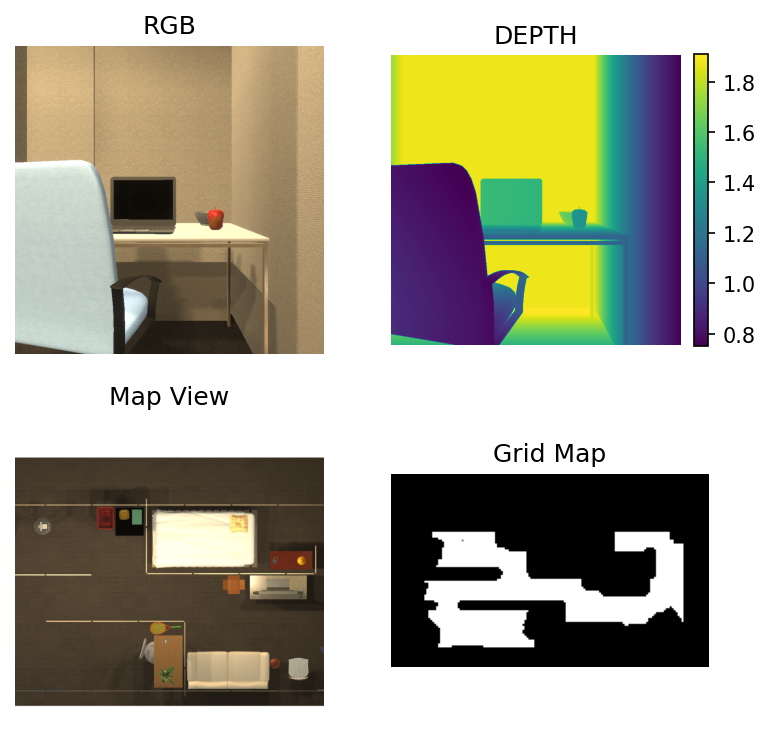

In [8]:
%matplotlib inline
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)

## Notice stepsize should be smaller than gridsize
stepsize = 0.06
margin = 0
sm = single_scenemap(scene_bounds,rstate,stepsize,margin)
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)


## Custom RRT

In [9]:
# from RRT import rrt
from RRT import rrt_with_pathsmoothing as rrts

In [10]:
initstate = 20
goalstate = 4000
# goalstate = 100000

pos = rstate[initstate]
goal = rstate[goalstate]

sm.setstartxyz(pos)
sm.setgoalxyz(goal)

In [11]:
def rotatepath(h_quan,path):
    Rpath = []
    for (x,y) in path:
        xrotate = h_quan-y-1
        yrotate = x
        Rpath.append([xrotate,yrotate])
    
    return Rpath


In [15]:
%matplotlib tk
# %matplotlib inline
np.random.seed(42)
random.seed(42)

rrtplanner = rrts.RRT(start=sm.start,goal=sm.goal,gridmap=sm.grid_map,\
    w_quan=sm.w_quan, h_quan=sm.h_quan,robot_radius=0.18,\
    expand_dis=0.1,max_iter=20000,stepsize=stepsize, rstate=sm.rstate)
path = rrtplanner.planning(animation=True)


path = rrts.path_smoothing(path,5000,sm.grid_map,margin=2)
path = np.array(path)
path = np.flip(path,0)

imshow = sm.plot(pos)
figure = plt.figure()
ax = figure.add_subplot(1,1,1)

Rpath = rotatepath(sm.h_quan,path)
Rpath = np.array(Rpath)
Rxpath,Rypath = Rpath[:,0],Rpath[:,1]

ax.plot(Rypath,Rxpath)
ax.imshow(imshow,cmap='gray')

plt.show()

Exception in Tkinter callback
Traceback (most recent call last):
  File "/home/terry-q/.pyenv/versions/3.9.10/lib/python3.9/tkinter/__init__.py", line 1892, in __call__
    return self.func(*args)
  File "/home/terry-q/.pyenv/versions/3.9.10/lib/python3.9/tkinter/__init__.py", line 814, in callit
    func(*args)
  File "/home/terry-q/.pyenv/versions/3.9.10/envs/ai2thor/lib/python3.9/site-packages/matplotlib/backends/_backend_tk.py", line 489, in delayed_destroy
    self.window.destroy()
  File "/home/terry-q/.pyenv/versions/3.9.10/lib/python3.9/tkinter/__init__.py", line 2312, in destroy
    self.tk.call('destroy', self._w)
KeyboardInterrupt


KeyboardInterrupt: 

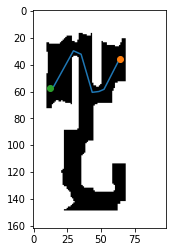

In [143]:
%matplotlib inline
xpath,ypath = path[:,0],path[:,1]

figure = plt.figure()
ax2 = figure.add_subplot(1,1,1)
ax2.plot(ypath,xpath)


ax2.plot(ypath[0],xpath[0],'o')
ax2.plot(ypath[-1],xpath[-1],'o')

ax2.imshow(sm.grid_map,cmap='gray')


plt.show()


In [144]:
xyzpath = []
y = rstate[0]['y']

for point in path:
    xyzpath.append(sm.grid2xyz(point,y))

In [146]:
# Teleport to initial position
import time

controller.step(
    action="Teleport",
    position = rstate[initstate]
)
frames = []
for e in range(len(xyzpath)-1):

    dx = xyzpath[e+1]['x'] - xyzpath[e]['x']
    dz = xyzpath[e+1]['z'] - xyzpath[e]['z']
    trot = math.atan2(dx,dz)*180/math.pi
    crot = controller.last_event.metadata['agent']['rotation']['y'] 
    rot = trot - crot
    event = controller.step(
        action="RotateRight",
        degrees=rot
    )
    frames.append(controller.last_event.third_party_camera_frames[0])

    if not event.metadata['lastActionSuccess']:
        print('Collision!')
        break
    
    event = controller.step(
        action="MoveAhead",
        moveMagnitude=math.sqrt(dx**2+dz**2)
    )
    frames.append(controller.last_event.third_party_camera_frames[0])
    
    if not event.metadata['lastActionSuccess']:
        print('Collision!')
        
    
    time.sleep(0.1)
    
controller.step(
    action="Teleport",
    position = controller.last_event.metadata['agent']['position']
)

position = controller.last_event.metadata['agent']['position']
position, rstate[goalstate]

Collision!
Collision!
Collision!
Collision!
Collision!
Collision!
Collision!


({'x': 4.199999809265137, 'y': 0.9009997248649597, 'z': -4.550000190734863},
 {'x': 4.150000095367432, 'y': 0.9009997248649597, 'z': -4.600000381469727})

## Custom Astar

In [53]:
initstate = 20
goalstate = 30
# goalstate = 100000

pos = rstate[initstate]
goal = rstate[goalstate]



In [54]:
sm.grid_map.shape

(98, 59)

In [55]:
cpos= sm.xyz2grid(pos)
cgoal = sm.xyz2grid(goal)
print(cpos,cgoal)
path = astar(sm.grid_map,cgoal,cpos)

[22, 38] [23, 39]
Done


In [56]:
def show_path(path,gridmap):
    gridmap_rgb = 1-np.expand_dims(gridmap,-1)
    gridmap_rgb = np.repeat(gridmap_rgb,3,-1)
    for p in path[1:-1]:
        gridmap_rgb[p[0],p[1],:] = [1,0,0]
    init = path[0]
    end = path[-1]
    gridmap_rgb[init[0],init[1],:] = [0,1,0]
    gridmap_rgb[end[0],end[1],:] = [0,1,1]
    gridmap_rgb = np.rot90(gridmap_rgb)
    plt.axis('off')
    plt.imshow(gridmap_rgb)

show_path(path,sm.grid_map)
# e=0

In [57]:
## When astar doesn't work

gridmap = sm.grid_map
init = cpos
end = cgoal

gridmap_rgb = np.expand_dims(gridmap,-1)
gridmap_rgb = np.repeat(gridmap_rgb,3,-1)

gridmap_rgb[init[0],init[1],:] = [0,1,0]
gridmap_rgb[end[0],end[1],:] = [0,1,1]
gridmap_rgb = np.rot90(gridmap_rgb)
# plt.axis('off')
plt.imshow(gridmap_rgb)

In [60]:
xyzpath = []
for e in path:
    pos = sm.grid2xyz(e,rstate[goalstate]['y'])
    xyzpath.append(pos)

xyzpath.insert(0,rstate[initstate])
xyzpath.append(rstate[goalstate])


In [61]:
controller.step(
    action="Teleport",
    position = rstate[initstate]
)

<ai2thor.server.Event at 0x7f1fec773370
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [63]:
# Teleport to initial position
import time

controller.step(
    action="Teleport",
    position = rstate[initstate]
)
frames = []
for e in range(len(xyzpath)-1):

    dx = xyzpath[e+1]['x'] - xyzpath[e]['x']
    dz = xyzpath[e+1]['z'] - xyzpath[e]['z']
    trot = math.atan2(dx,dz)*180/math.pi
    crot = controller.last_event.metadata['agent']['rotation']['y'] 
    rot = trot - crot
    event = controller.step(
        action="RotateRight",
        degrees=rot
    )
    frames.append(controller.last_event.third_party_camera_frames[0])

    if not event.metadata['lastActionSuccess']:
        print('Collision!')
        break
    
    event = controller.step(
        action="MoveAhead",
        moveMagnitude=math.sqrt(dx**2+dz**2)
    )
    frames.append(controller.last_event.third_party_camera_frames[0])
    
    if not event.metadata['lastActionSuccess']:
        print('Collision!')
        break
    
    time.sleep(0.5)
    
controller.step(
    action="Teleport",
    position = controller.last_event.metadata['agent']['position']
)

<ai2thor.server.Event at 0x7f1fec7732b0
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [ ]:
pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]
print(pos)
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)

In [ ]:
video = ImageSequenceClip(frames, fps=10)
video.write_gif('temp.gif')


In [ ]:
from IPython.display import Image as IM
with open('temp.gif','rb') as file:
    display(IM(file.read(),width = 300))

## Built-in path planning

In [ ]:
def rstate2pos(rstate):
    ls = []
    ls.append(rstate['x'])
    ls.append(rstate['z'])
    
    return ls

In [ ]:
initstate = 20
goalstate = 100000

from ai2thor.util.metrics import (
    get_shortest_path_to_point
)
incpos = rstate[initstate]
ingoal = rstate[goalstate]

inpath = get_shortest_path_to_point(
   controller=controller,
    target_position= ingoal,
    initial_position= incpos,
    allowed_error=0
)

# Adjust invalid depth -> Don't know why this happens
for point in inpath:
    point['y'] = incpos['y']


savepath = []
for point in inpath:
    xzpoint = [point['x'], point['z']]
    temp = sm.gridmap_pos(xzpoint)
    savepath.append(temp)

print(savepath)
show_path(savepath,sm.grid_map)

In [ ]:
## When built-in doesn't work

gridmap = 1-sm.grid_map
init = sm.gridmap_pos(rstate2pos(incpos))
end = sm.gridmap_pos(rstate2pos(inpath[-1]))

gridmap_rgb = np.expand_dims(gridmap,-1)
gridmap_rgb = np.repeat(gridmap_rgb,3,-1)

gridmap_rgb[init[0],init[1],:] = [0,1,0]
gridmap_rgb[end[0],end[1],:] = [0,1,1]
gridmap_rgb = np.rot90(gridmap_rgb)
plt.axis('off')
plt.imshow(gridmap_rgb)

In [ ]:
controller.step(dict(action='GetReachablePositions'))

temp = controller.last_event.metadata['actionReturn']


In [ ]:
import time

controller.step(
    action="Teleport",
    position = rstate[initstate],
    rotation=dict(x=0, y=40, z=0),
)

frames = []
frames.append(controller.last_event.third_party_camera_frames[0])
for e in range(len(inpath)-1):

    dx = inpath[e+1]['x'] - inpath[e]['x']
    dz = inpath[e+1]['z'] - inpath[e]['z']
    trot = math.atan2(dx,dz)*180/math.pi
    crot = controller.last_event.metadata['agent']['rotation']['y'] 
    rot = trot - crot
    event = controller.step(
        action="RotateRight",
        degrees=rot
    )
    frames.append(controller.last_event.third_party_camera_frames[0])
    if not event.metadata['lastActionSuccess']:
        print('Collision!')
        # break
    
    
    event = controller.step(
        action="MoveAhead",
        moveMagnitude=math.sqrt(dx**2+dz**2)
    )
    frames.append(controller.last_event.third_party_camera_frames[0])
    if not event.metadata['lastActionSuccess']:
        print('Collision!')
        # break
    
    time.sleep(0.5)

controller.step(
    action="Teleport",
    position = controller.last_event.metadata['agent']['position']
)


In [ ]:
pos = controller.last_event.metadata['agent']['position']
print("Current position:",pos, "Goal position", rstate[goalstate])
pos = [pos['x'],pos['z']]
imshow_grid = sm.plot(pos)
plot_frames(controller.last_event,imshow_grid)

In [ ]:
video = ImageSequenceClip(frames, fps=10)
video.write_gif('temp.gif')


In [ ]:
from IPython.display import Image as IM
with open('temp.gif','rb') as file:
    display(IM(file.read(),width = 300))